In [1]:
import numpy as np
from sklearn.decomposition import PCA
from torchvision import datasets, transforms, models
from latentmi import lmi, ksg
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter


import torch.nn as nn
import torch.optim as optim

device='cuda'

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        self.vit = models.vit_b_16(pretrained=True)
        in_feat = self.vit.heads[0].in_features  # grab it from the first layer!
        self.vit.heads = nn.Linear(in_feat, num_classes)  # new head, who dis? :)

    def forward(self, x):
        return self.vit(x)
    
def train_model(model, dataloader, epochs=5, scale=0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.numpy(), labels.numpy()  # to numpy
            if scale > 0:
                inputs = gaussian_noise(inputs, scale)  # downsample
            inputs, labels = torch.tensor(inputs).to(device).float(), torch.tensor(labels).to(device)  # back to tensor

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

# pca wrapper (top 16 pcs!)
def compute_pca(images, n_components=16):
    flat_images = images.reshape(images.shape[0], -1)
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(flat_images)  # normalize!
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled_images)
    return pcs

def resample_one_v_all(true_labels, target_label):
    target_indices = []
    other_indices = []
    for i, label in enumerate(true_labels):
        if target_label == label:
            target_indices.append(i)
        else:
            other_indices.append(i)

    other_indices = np.random.choice(other_indices, len(target_indices), replace=False)
    indices = np.concatenate([target_indices, other_indices])
    return indices.astype(int)


def estimate_mi_repr(model, dataloader, scale=0):
    model.eval()
    true_labels = []
    last_layer_reprs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.numpy()  # to numpy
            if scale > 0:
                inputs = gaussian_noise(inputs, scale)  # downsample
            inputs = torch.tensor(inputs).to(device).float()  # back to tensor
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            true_labels.append(labels.numpy())
            last_layer_reprs.append(outputs.cpu().numpy())

    true_labels = np.concatenate(true_labels)
    last_layer_reprs = np.concatenate(last_layer_reprs)

    MIs = []
    N_samples = []
    labels = []

    for label in np.unique(true_labels):
        N_samples.append(np.sum(true_labels == label))
        labels.append(label)
        idx = resample_one_v_all(true_labels, label)
        bin_y = true_labels[idx] == label
        reprs = last_layer_reprs[idx]
        
        MIs.append(np.nanmean(lmi.estimate(bin_y.reshape(-1, 1), reprs)[0]))

    # all labels → one-hot!
    uniques = np.unique(true_labels).tolist()
    n_classes = len(uniques)
    one_hot_labels = np.eye(n_classes)[[uniques.index(s) for s in true_labels]]
    MIs.append(np.nanmean(lmi.estimate(one_hot_labels, last_layer_reprs, N_dims=16)[0]))
    N_samples.append(len(true_labels))
    labels.append('all')

    print(MIs)

    return MIs, N_samples, labels

def gaussian_noise(images, scale):
    return np.random.normal(size=images.shape)*scale + images


In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # ensure RGB
    transforms.Resize((224, 224)),  # resize to ViT input size
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize
])

# load dataset
Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform)

# get class labels
labels = Caltech101.y  # class indices for the dataset

# count occurrences of each class
class_counts = Counter(labels)

# find top n largest classes
top_n = 5
top_n_classes = [cls for cls, _ in class_counts.most_common(top_n)]

# subset the dataset to include only samples from these top classes
indices = [i for i, label in enumerate(labels) if label in top_n_classes]
subset = torch.utils.data.Subset(Caltech101, indices)

# split the subset into train and validation sets
N = len(subset)
print(f"{N} total samples")
train_set, val_set = torch.utils.data.random_split(subset, [N//2, N - N//2])

# create data loaders
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

Files already downloaded and verified
2707 total samples


In [4]:
d = {
    "Scale" : [],
    "MI" : [],
    "Class label" : [],
    "N instances of label" : []
}

MIs = []
scales = np.logspace(-1, 3, 10)

# process each factor
for scale in scales:

    model = ViTClassifier(num_classes=101)
    model.to('cuda')
    train_model(model, data_loader, epochs=10, scale=scale)

    # estimate mutual info
    mi, n_inst, labels = estimate_mi_repr(model, val_loader, scale=scale)
    d['MI'] += mi
    d['Scale'] += [scale] * len(mi)
    d['Class label'] += labels
    d["N instances of label"] += n_inst

/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 1.1171
Epoch 2/10, Loss: 0.0736
Epoch 3/10, Loss: 0.0245
Epoch 4/10, Loss: 0.0189
Epoch 5/10, Loss: 0.0078
Epoch 6/10, Loss: 0.0237
Epoch 7/10, Loss: 0.0171
Epoch 8/10, Loss: 0.0118
Epoch 9/10, Loss: 0.0105
Epoch 10/10, Loss: 0.0118
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[1.0030999159634395, 0.9654440703336552, 0.9992072224319503, 1.000332989887557, 1.0055427371208674, 2.2137036210417738]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 1.2383
Epoch 2/10, Loss: 0.0876
Epoch 3/10, Loss: 0.0208
Epoch 4/10, Loss: 0.0192
Epoch 5/10, Loss: 0.0119
Epoch 6/10, Loss: 0.0242
Epoch 7/10, Loss: 0.0147
Epoch 8/10, Loss: 0.0071
Epoch 9/10, Loss: 0.0085
Epoch 10/10, Loss: 0.0104
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9964757946261719, 1.0031384745117782, 1.0017334873513162, 0.9991726938443289, 0.9927484333284566, 2.1716221891573433]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 1.3521
Epoch 2/10, Loss: 0.1311
Epoch 3/10, Loss: 0.0462
Epoch 4/10, Loss: 0.0299
Epoch 5/10, Loss: 0.0181
Epoch 6/10, Loss: 0.0151
Epoch 7/10, Loss: 0.0109
Epoch 8/10, Loss: 0.0097
Epoch 9/10, Loss: 0.0096
Epoch 10/10, Loss: 0.0080
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9812020932561131, 0.9999457967554273, 1.0015170659605885, 1.0013638415528943, 1.0019918886626553, 2.1975311040194736]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 1.9098
Epoch 2/10, Loss: 0.9008
Epoch 3/10, Loss: 0.5806
Epoch 4/10, Loss: 0.3552
Epoch 5/10, Loss: 0.2038
Epoch 6/10, Loss: 0.1223
Epoch 7/10, Loss: 0.1262
Epoch 8/10, Loss: 0.0769
Epoch 9/10, Loss: 0.0674
Epoch 10/10, Loss: 0.0529
epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻[0.9838129986770773, 0.9803616745311925, 0.9634966306989358, 0.9643237765541101, 0.9499646962625841, 2.1373641974317366]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.0344
Epoch 2/10, Loss: 1.4519
Epoch 3/10, Loss: 1.3041
Epoch 4/10, Loss: 1.2365
Epoch 5/10, Loss: 1.2215
Epoch 6/10, Loss: 1.1280
Epoch 7/10, Loss: 1.0641
Epoch 8/10, Loss: 1.0127
Epoch 9/10, Loss: 0.9936
Epoch 10/10, Loss: 1.0241
epoch 216 (of max 300) 🌻🌻🌻🌻🌻🌻🌻[0.4038520358742841, 0.4750135456923852, 0.5777814393602498, 0.49168149645267295, 0.053821029962676646, 1.1251076869493937]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.1477
Epoch 2/10, Loss: 1.5662
Epoch 3/10, Loss: 1.4773
Epoch 4/10, Loss: 1.3999
Epoch 5/10, Loss: 1.3473
Epoch 6/10, Loss: 1.3038
Epoch 7/10, Loss: 1.2891
Epoch 8/10, Loss: 1.2736
Epoch 9/10, Loss: 1.2554
Epoch 10/10, Loss: 1.2307
epoch 101 (of max 300) 🌻🌻🌻🌻🌻[0.08666556894160456, 0.1506159423337902, 0.3777578375748761, 0.2881122639335683, -0.0013758623723065524, 0.6235016661420977]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.2630
Epoch 2/10, Loss: 1.6193
Epoch 3/10, Loss: 1.5649
Epoch 4/10, Loss: 1.5604
Epoch 5/10, Loss: 1.5269
Epoch 6/10, Loss: 1.4955
Epoch 7/10, Loss: 1.4591
Epoch 8/10, Loss: 1.4278
Epoch 9/10, Loss: 1.4087
Epoch 10/10, Loss: 1.4482
epoch 116 (of max 300) 🌻🌻🌻[0.11962093527460126, 0.109821446310433, 0.1907622834736757, 0.06872418172274601, 0.008463034633549756, 0.16632014578876966]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.7165
Epoch 2/10, Loss: 1.6392
Epoch 3/10, Loss: 1.5862
Epoch 4/10, Loss: 1.5638
Epoch 5/10, Loss: 1.5641
Epoch 6/10, Loss: 1.5662
Epoch 7/10, Loss: 1.5529
Epoch 8/10, Loss: 1.5505
Epoch 9/10, Loss: 1.5415
Epoch 10/10, Loss: 1.5402
epoch 94 (of max 300) 🌻🌻🌻�🌻[0.026777958212788087, 0.007516002812367482, 0.03091648985736175, 0.056533467674777314, -0.06575676401078409, 0.03043699880084392]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.2275
Epoch 2/10, Loss: 1.6394
Epoch 3/10, Loss: 1.6045
Epoch 4/10, Loss: 1.5879
Epoch 5/10, Loss: 1.5722
Epoch 6/10, Loss: 1.5534
Epoch 7/10, Loss: 1.5535
Epoch 8/10, Loss: 1.5393
Epoch 9/10, Loss: 1.5444
Epoch 10/10, Loss: 1.5427
epoch 106 (of max 300) 🌻🌻🌻[-0.02967293312626366, -0.016965848585649198, 0.0012411464061671041, 0.020748570620549946, -0.033871774888354834, -0.009435154359286126]


/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.3078
Epoch 2/10, Loss: 1.6248
Epoch 3/10, Loss: 1.5822
Epoch 4/10, Loss: 1.5835
Epoch 5/10, Loss: 1.5703
Epoch 6/10, Loss: 1.5535
Epoch 7/10, Loss: 1.5469
Epoch 8/10, Loss: 1.5596
Epoch 9/10, Loss: 1.5436
Epoch 10/10, Loss: 1.5467
epoch 95 (of max 300) 🌻🌻🌻�🌻🌻[-0.024714897769993933, -0.061118660794510345, 0.005483912764559351, 0.031749563709974754, 0.08235895109604953, -0.04858433274191786]


In [8]:
import pandas as pd
import seaborn as sns

In [9]:
df = pd.DataFrame(data=d)
df.to_csv("../results/ViT_Caltech101_Gaussian.csv")
# df

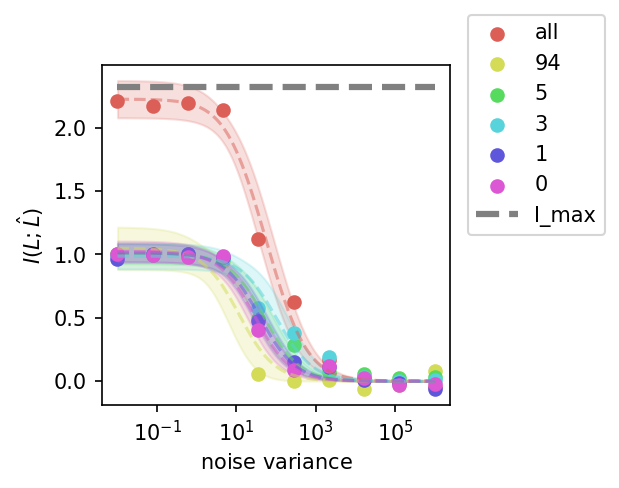

In [10]:
from lmfit import Model

def info_scaling(x, A, B):
    return 0.5 * np.log2(((1/x)*B+ 1)/(1+A*(1/x)))

fig = plt.figure(figsize=(3,3), dpi=150)


classes = df[df['N instances of label'] > 100]['Class label'].unique()
palette = sns.color_palette("hls", len(classes))

for i, x in enumerate(classes[::-1]):
    # prepare data
    x_data = df[df['Class label'] == x]['Scale']**2
    y_data = df[df['Class label'] == x]['MI']

    # create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    # generate fit line
    x_fit = np.logspace(-2, 6, 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)

    # calculate confidence bands
    y_upper = result.eval_uncertainty(params=result.params, 
                                      x=x_fit, sigma=2)
    y_lower = -y_upper

    # plot fit and data
    plt.plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=palette[i], alpha=0.2)
    plt.scatter(x_data, y_data, color=palette[i], label=x)

I_max = np.log2(top_n)
plt.plot([np.min(x_fit), np.max(x_fit)], [I_max, I_max], linestyle='--', 
         color='grey', label='I_max', lw=3)


plt.xlabel(r'$\text{noise variance}$')
plt.ylabel(r'$I(L; \hat{L})$')
plt.xscale('log')
plt.legend(loc=(1.05, 0.5))